In [89]:
#IMPORT STATEMENTS
import selenium
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # supress scikit 'future warnings'
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.optimize import linear_sum_assignment
import matplotlib         
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import norm, kurtosis
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats
import math
import pickle
import random
import copy
import itertools
from dataclasses import dataclass
random.seed(42)
import torch
import torch.nn as nn
#from basketball_reference_scraper import ask_matches
from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot, get_player_suffix, lookup

In [90]:
# Data processing and modification cell
# This entire cell essentially modifies the data into a format
# that is usable for the rest of the code
# Takes data from scraper and puts it into necessary format

import os
# assign directory
directory = 'Player_CSV'
 
def true_to_one(input):
    if input:
        return 1
    else:
        return 0

def home_to_one(input):
    if input == "HOME":
        return 1
    else:
        return 0

def win_to_one(input):
    if input == "WIN":
        return 1
    else:
        return 0

def convert_df(dataframe):
    df = dataframe
    df['active'] = df['active'].apply(true_to_one)
    df['location'] = df['location'].apply(home_to_one)
    df['outcome'] = df['outcome'].apply(win_to_one)
    df = df.drop(columns=['date', 'team', 'opponent'])
    return df

X = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        player_df = pd.read_csv(f)
        player_df = convert_df(player_df)
        player_np = player_df.to_numpy()
        player_np = np.transpose(player_np)
        if np.shape(player_np)[1] >= 10:
            X.append(player_np)
        #print(player_np)
        
#print(X)

fantasy_score_arr = np.array([0,1,0,0,0,0,2,-1,1,0,1,-1,1,1,2,4,4,-2,0,0])
fantasy_score_arr = np.reshape(fantasy_score_arr, (20,1))

In [91]:
"""
count = 0
for arr in X:
    if np.shape(arr)[1] > 82:
        count += 1
"""
#print(count)
#print(X[0])

X_mod = []

for arr in X:
    splits = np.shape(arr)[1]//10
    for i in range(splits):
        X_mod.append(arr[:, i:i+10])

print(len(X))
print(len(X_mod))

print(np.shape(X_mod[32892]))

8304
43695
(20, 10)


In [92]:
train_seq_in = []
train_seq_out = []
list_in_seq = []
list_hidden_seq = []
list_out_seq = []

for example in X_mod:
    train_seq_in.append(example[:, :-1].T)
    train_seq_out.append(example[:, 1:].T)
    
    check1 = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check_hide = np.zeros((1, np.shape(example[:, :-1].T)[0], np.shape(example[:, :-1].T)[1]))
    check2 = np.zeros((1, 9, 1))
    
    
    check1[0] = example[:, :-1].T
    pre_score_arr = example[:, 1:].T
    post_score_arr = np.reshape(np.dot(pre_score_arr, fantasy_score_arr), (9,1))
    check2[0] = post_score_arr
    
    
    list_in_seq.append(torch.Tensor(check1))
    list_hidden_seq.append(torch.Tensor(pre_score_arr))
    list_out_seq.append(torch.Tensor(check2))
    
print(np.shape(train_seq_in[0]))
print(len(train_seq_in))
print(len(train_seq_out))

train_seq_in = torch.Tensor(train_seq_in)
train_seq_out = torch.Tensor(train_seq_out)


(9, 20)
43695
43695


In [93]:
print(train_seq_in)
print(train_seq_in.size())
print(list_in_seq[0].size())

tensor([[[  1.0000,   0.0000,  -1.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  1.0000,   2.0000,   4.0000,  ...,   0.0000,   0.0000,   1.7000],
         [  1.0000,   2.0000,   2.0000,  ...,   0.0000,   0.0000,   1.7000],
         ...,
         [  1.0000,  11.0000, -13.0000,  ...,   2.0000,   4.0000,   7.0000],
         [  1.0000,   3.0000,  -8.0000,  ...,   1.0000,   2.0000,   0.1000],
         [  1.0000,   0.0000,  -2.0000,  ...,   0.0000,   0.0000,   3.1000]],

        [[  1.0000,   2.0000,   4.0000,  ...,   0.0000,   0.0000,   1.7000],
         [  1.0000,   2.0000,   2.0000,  ...,   0.0000,   0.0000,   1.7000],
         [  1.0000,   5.0000,   1.0000,  ...,   0.0000,   3.0000,   4.1000],
         ...,
         [  1.0000,   3.0000,  -8.0000,  ...,   1.0000,   2.0000,   0.1000],
         [  1.0000,   0.0000,  -2.0000,  ...,   0.0000,   0.0000,   3.1000],
         [  1.0000,   2.0000,  -7.0000,  ...,   0.0000,   1.0000,   1.9000]],

        [[  1.0000,   2.0000,   2.0000,  ...

In [104]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
# Instantiate the model with hyperparameters
model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)

# Define hyperparameters
n_epochs = 11
lr=0.03

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    for index, in_seq in enumerate(list_in_seq):
        #print(in_seq.size())
        out_seq = list_out_seq[index]
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        output, hidden = model(in_seq)
        
        #print(output.size())
        #print(in_seq)
        #print(out_seq)
        loss = criterion(output, out_seq.float())
        
        #print(output)
        #print(out_seq)
        #print(loss)
        
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        epoch_loss += loss.item()
        
        #if index%10000 == 0:
    avg_epoch_loss = epoch_loss/len(list_in_seq)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Average Loss: {:.4f}".format(avg_epoch_loss))      
        
        
        
        
        
        
        

Epoch: 1/11............. Loss: 246.2452
Epoch: 2/11............. Loss: 246.0355
Epoch: 3/11............. Loss: 245.9428
Epoch: 4/11............. Loss: 245.9805
Epoch: 5/11............. Loss: 245.8175
Epoch: 6/11............. Loss: 245.7527
Epoch: 7/11............. Loss: 246.3848
Epoch: 8/11............. Loss: 246.7145
Epoch: 9/11............. Loss: 246.7240
Epoch: 10/11............. Loss: 246.7237
Epoch: 11/11............. Loss: 246.7237


Epoch: 1/10............. Average Loss: 12.4856


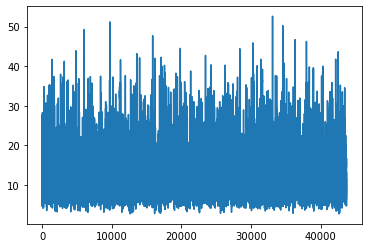

Epoch: 2/10............. Average Loss: 12.4837


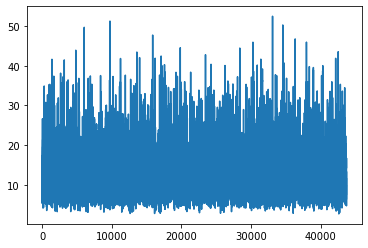

Epoch: 3/10............. Average Loss: 12.4842


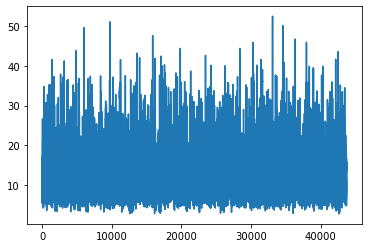

KeyboardInterrupt: 

In [109]:
disp_graph_bool = True

class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
# Instantiate the model with hyperparameters
model = Model(input_size=20, output_size=1, hidden_dim=20, n_layers=1)

# Define hyperparameters
n_epochs = 10
lr=0.02

# Define Loss, Optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    per_epoch_loss_arr = np.array([])
    random.shuffle(list_in_seq)
    for index, in_seq in enumerate(list_in_seq):
        #print(in_seq.size())
        out_seq = list_out_seq[index]
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        output, hidden = model(in_seq)
        
        #print(output.size())
        #print(in_seq)
        #print(out_seq)
        loss = criterion(output, out_seq.float())
        
        #print(output)
        #print(out_seq)
        #print(loss)
        
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        
        epoch_loss += loss.item()
        per_epoch_loss_arr = np.append(per_epoch_loss_arr, loss.item())
        
        #if index%10000 == 0:
    avg_epoch_loss = epoch_loss/len(list_in_seq)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Average Loss: {:.4f}".format(avg_epoch_loss))      
    
    if disp_graph_bool:
        plt.clf()
        plt.plot(np.arange(len(list_in_seq)), per_epoch_loss_arr)
        plt.show()
        
        
        
        
        